<a href="https://colab.research.google.com/github/Hanbin-git/kaggle/blob/main/notebook5b0ac32689.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

stanford_rna_3d_folding_path = kagglehub.competition_download('stanford-rna-3d-folding')
biniroun_my_protenix_checkpoint_path = kagglehub.dataset_download('biniroun/my-protenix-checkpoint')
biniroun_componetns_path = kagglehub.dataset_download('biniroun/componetns')
biniroun_components_path = kagglehub.dataset_download('biniroun/components')
biniroun_componetns20250509_path = kagglehub.dataset_download('biniroun/componetns20250509')
iafoss_rna_starter_0_186_lb_path = kagglehub.notebook_output_download('iafoss/rna-starter-0-186-lb')
ishgirwan_protenix_inference_path = kagglehub.notebook_output_download('ishgirwan/protenix-inference')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/protenix-inference/__results__.html
/kaggle/input/protenix-inference/__huggingface_repos__.json
/kaggle/input/protenix-inference/submission.csv
/kaggle/input/protenix-inference/__notebook__.ipynb
/kaggle/input/protenix-inference/__output__.json
/kaggle/input/protenix-inference/custom.css
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_sample_2.cif
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_summary_confidence_sample_3.json
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_summary_confidence_sample_0.json
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_sample_4.cif
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_summary_confidence_sample_1.json
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42_sample_1.cif
/kaggle/input/protenix-inference/output/R1107/seed_42/predictions/R1107_seed_42

In [ ]:
!rm -rf /af3-dev/release_data
!mkdir -p /af3-dev
!ln -s /kaggle/input/my-protenix-checkpoint /af3-dev/release_data
!ls /af3-dev/release_data


model_v0.2.0.pt


In [ ]:
!ls /af3-dev/release_data

model_v0.2.0.pt


In [ ]:
MODEL_TYPE = 'protenix'
VALIDATION = True

if MODEL_TYPE == 'protenix' and VALIDATION:
    !pip install --no-deps protenix -q
    !pip install biopython==1.80 ml-collections biotite==1.0.1 rdkit -q

# ❌ ln -s 제거 (불필요함)
# ✅ 대신 아래처럼 모델 경로만 정확히 지정
from configs.configs_inference import inference_configs
inference_configs['load_checkpoint_path'] = '/kaggle/input/my-protenix-checkpoint/model_v0.2.0.pt'


In [ ]:
# 필수 모듈
import os, sys, time, re, warnings
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

# CIF 파일 경로 환경 변수 설정
import os
os.environ["PROTENIX_CCD_PATH"] = "/kaggle/input/components/components.v20240608.cif"

# 경로 추가
RHONET_DIR = '/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main'
sys.path.append(RHONET_DIR)

# USalign binary 경로
USALIGN = '/kaggle/input/usalign/USalign'


In [ ]:
def write_xyz_to_pdb(df, pdb_file, xyz_id=1):
    def write_line(serial, name, res, chain, resnum, x, y, z):
        return f'ATOM  {serial:>5d}  {name:<5s} {res:<3s} {chain}{resnum:>4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C\n'

    with open(pdb_file, 'w') as f:
        for _, row in df.iterrows():
            if all(abs(row[f'{axis}_{xyz_id}']) < 1e5 for axis in 'xyz'):
                f.write(write_line(int(row['resid']), "C1'", row['resname'], 'A', int(row['resid']),
                                   row[f'x_{xyz_id}'], row[f'y_{xyz_id}'], row[f'z_{xyz_id}']))

def call_usalign(predict_df, truth_df):
    write_xyz_to_pdb(predict_df, 'pred.pdb', xyz_id=1)
    write_xyz_to_pdb(truth_df, 'true.pdb', xyz_id=1)
    out = os.popen(f"{USALIGN} pred.pdb true.pdb -atom \" C1'\" -m -").read()
    try:
        tm_score = float(re.findall(r'TM-score=\s+([\d.]+)', out)[1])
        return tm_score
    except:
        return None

def parse_output_to_df(output, seq, target_id):
    result = []
    for i, base in enumerate(seq):
        entry = {
            "ID": f"{target_id}_{i+1}", "resname": base, "resid": i+1
        }
        for j in range(output.shape[0]):
            entry.update({
                f'x_{j+1}': output[j, i, 0].item(),
                f'y_{j+1}': output[j, i, 1].item(),
                f'z_{j+1}': output[j, i, 2].item(),
            })
        result.append(entry)
    return pd.DataFrame(result)


In [ ]:
from configs.configs_base import configs as configs_base
from configs.configs_data import data_configs
from protenix.config.config import parse_configs
from runner.inference import InferenceRunner, update_inference_configs
from protenix.data.infer_data_pipeline import InferenceDataset

# 설정 통합
configs_base["use_deepspeed_evo_attention"] = False
configs_base["model"]["N_cycle"] = 10
configs_base["sample_diffusion"]["N_sample"] = 1
configs_base["sample_diffusion"]["N_step"] = 200

from configs.configs_inference import inference_configs  # 이미 지정됨
configs = {**configs_base, **{"data": data_configs}, **inference_configs}
configs = parse_configs(configs=configs, fill_required_with_null=True)
runner = InferenceRunner(configs)

# 데이터 로드
label_df = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
label_df['target_id'] = label_df['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
seq_df = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
seq_df['tm_score'] = np.nan


train scheduler 16.0
inference scheduler 16.0
Diffusion Module has 16.0


In [ ]:
class DictDataset(InferenceDataset):
    def __init__(self, seq_list, id_list):
        self.inputs = [{
            "sequences": [{"rnaSequence": {"sequence": seq, "count": 1}}],
            "name": tid
        } for seq, tid in zip(seq_list, id_list)]

dataset = DictDataset(seq_df['sequence'], seq_df['target_id'])


warnings.filterwarnings("ignore")
start_time = time.time()

for i in tqdm(range(len(dataset))):
    seq = seq_df.loc[i, 'sequence']
    if len(seq) > 300:
        continue
    target_id = '_'.join(seq_df.loc[i, 'target_id'].split('_')[:-1])
    truth_df = label_df[label_df['target_id'] == target_id].reset_index(drop=True)
    if len(truth_df) < 3: continue

    data, atom_array, error = dataset[i]
    if error: continue
    new_cfg = update_inference_configs(configs, data["N_token"].item())
    runner.update_model_configs(new_cfg)

    try:
        pred = runner.predict(data)
        coords = pred['coordinate'][:, data['input_feature_dict']['atom_to_tokatom_idx'] == 12]
        pred_df = parse_output_to_df(coords[:1], seq, target_id)
        tm_score = call_usalign(pred_df, truth_df)
        seq_df.loc[i, 'tm_score'] = tm_score
    except:
        continue

    if time.time() - start_time > (12 * 3600 - 600):
        break

# 저장
seq_df.to_csv("tm_scores.csv", index=False)


100%|██████████| 844/844 [00:08<00:00, 96.78it/s] 


In [ ]:
class DictDataset(InferenceDataset):
    def __init__(self, seq_list: list, id_list: list = None, use_msa: bool = False):
        self.use_msa = use_msa
        if isinstance(id_list, type(None)):
            self.inputs = [{
                "sequences": [{"rnaSequence": {"sequence": seq, "count": 1}}],
                "name": "query"
            } for seq in seq_list]
        else:
            self.inputs = [{
                "sequences": [{"rnaSequence": {"sequence": seq, "count": 1}}],
                "name": i
            } for seq, i in zip(seq_list, id_list)]


100%|██████████| 844/844 [00:10<00:00, 80.33it/s] 


✅ 평균 TM-score: nan


<Axes: >

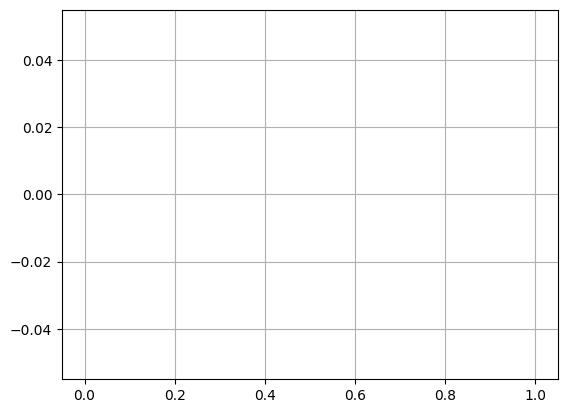

In [ ]:
def get_truth_df(target_id):
    truth_df = LABEL_DF[LABEL_DF['target_id'] == target_id]
    return truth_df.reset_index(drop=True)

import warnings
warnings.filterwarnings("ignore")

# 1. 데이터 불러오기
seq_df = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
label_df = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
label_df["target_id"] = label_df["ID"].apply(lambda x: "_".join(x.split("_")[:-1]))

# 2. get_truth_df() 함수에서 참조할 전역 변수 설정
LABEL_DF = label_df

# 3. DictDataset 구성
dataset = DictDataset(seq_list=seq_df["sequence"], id_list=seq_df["target_id"], use_msa=False)


# 4. 추론 실행
seq_df["protenix_tm_score"] = None
for i, seq in tqdm(enumerate(seq_df["sequence"]), total=len(seq_df)):
    if seq_df.loc[i, "protenix_tm_score"] is not None:
        continue
    if len(seq) > 300:
        continue

    target_id = seq_df.loc[i, "target_id"]
    truth_df = get_truth_df(target_id)
    if sum(~np.isnan(truth_df.x_1)) < 3:
        continue

    data, atom_array, err = dataset[i]
    if err != "":
        continue

    new_cfg = update_inference_configs(configs, data["N_token"].item())
    runner.update_model_configs(new_cfg)

    try:
        prediction = runner.predict(data)
        coords = prediction["coordinate"][:, data["input_feature_dict"]["atom_to_tokatom_idx"] == 12]
        result_df = parse_output_to_df(coords[:1], seq, target_id)[0]
        tm_score, _ = call_usalign(result_df, truth_df, verbose=0)
        seq_df.loc[i, "protenix_tm_score"] = tm_score
    except Exception as e:
        print(f"❌ 실패: {target_id} → {e}")
        continue

    if (time.time() - time0) > (12 * 3600 - 360):
        print("⏳ 시간 초과. 중단합니다.")
        break

# 5. 결과 저장
seq_df.to_csv("tm_scores.csv", index=False)
print("✅ 평균 TM-score:", seq_df["protenix_tm_score"].mean())
seq_df["protenix_tm_score"].hist()


In [ ]:
import protenix.data.ccd as ccd

ccd.COMPONENTS_FILE = "/kaggle/input/components/components.v20240608.cif"
ccd.RDKIT_MOL_FILE = "/kaggle/input/components/components.v20240608.cif.rdkit_mol.pkl"


In [ ]:
dataset = DictDataset(seq_list=seq_df["sequence"], id_list=seq_df["target_id"], use_msa=False)


In [ ]:
test_idx = 0
test_seq = seq_df.loc[test_idx, "sequence"]
test_id = seq_df.loc[test_idx, "target_id"]
truth_df = get_truth_df(test_id)

data, atom_array, err = dataset[test_idx]
print("⚠️ Error 메시지:", err)

if "N_token" in data:
    new_cfg = update_inference_configs(configs, data["N_token"].item())
    runner.update_model_configs(new_cfg)

    prediction = runner.predict(data)
    coords = prediction["coordinate"][:, data["input_feature_dict"]["atom_to_tokatom_idx"] == 12]

    result_df = parse_output_to_df(coords[:1], test_seq, test_id)[0]
    tm_score, _ = call_usalign(result_df, truth_df, verbose=1)
    print("✅ 단일 TM-score:", tm_score)
else:
    print("❌ N_token 없음 → 추론 불가")


⚠️ Error 메시지: CCD components file /usr/local/lib/python3.11/dist-packages/release_data/ccd_cache/components.v20240608.cif.rdkit_mol.pkl not found, please download it to your DATA_ROOT_DIR before running.See https://github.com/bytedance/Protenix:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/protenix/data/infer_data_pipeline.py", line 211, in __getitem__
    data, atom_array, _ = self.process_one(
                          ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/protenix/data/infer_data_pipeline.py", line 101, in process_one
    sample2feat = SampleDictToFeatures(
                  ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/protenix/data/json_to_feature.py", line 34, in __init__
    self.input_dict = add_entity_atom_array(single_sample_dict)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/protenix/data/json_parser.py", line 609, in add